# Network reconstruction based on scIDseq data 

In this notebook we explore the single-cell MRA and CNR network reconstructions of primary human epidermal stem cells treated, stimulated for 30 minutes with EGF only (Control) or with EGF + a p70 or RPS6 inhibitor.

Cells were also classified into 9 distinct cell state clusters based on epitopes that did not show a differential response to the inhibitor treatment. By fitting a linear model relating epitope expression to drug treatment and cell state cluster, we identified a significant interaction between drug treatment and cell state cluster for RPS6. We found two clusters of particular interest: Cluster 5 and Cluster 9.

<!--   * **Cluster 5** has high expression of both H3_P and CYCLIN_B1 (and to a lesser extend, H2A_P), which is affected by RSKi. For H3_P and H2A_P the upregulation in cluster 5 is repressed, whereas for CYCLIN_B1 it is extra pronounced.
  * In **cluster 9**, a large number of antibodies show a similar trend, where they are upregulated upon p70S6K inhibition. These include CYCLIN_E, FAK, SCR_P, JAK1_P, STAT5_P, and phospho-NFkB/p65. SRC_P also shows this trent in cluster 6. Surprisingly, AKT2 also shows this profile.
   -->
To reduce computational load, we will first fix the model topology. We do this by starting with a network with canonical interactions, including all substrate-kinase interaction between nodes from phospho-site plus, and adding edges if they are recurrently added in a bootstrap. To this end, we initially ignore differences between clusters.


We will these then explore the clusters by performing CNR of all clusters simulateneously to explore the general differences between the clusters, and which edges are relatively stable.


In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections
import scmra
import networkx as nx
import random
import itertools
import pickle
import cplex

%matplotlib inline  
%load_ext autoreload

%autoreload 2

# Temporary fix for autocompletion. See this issue 
# https://github.com/conda-forge/conda-forge-repodata-patches-feedstock/issues/81#event-3664361521
%config Completer.use_jedi = False

# Fix some font issues
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
#sns.set_context("note")

Load and the data, and separate the cell-state and treatment annotations.

In [2]:
dat = pd.read_csv("../data/processed/TMM_normalised_with_clusters_matrix.csv")
psp = pd.read_csv("../data/annotations/substrate-kinase-psp.tsv", sep="\t")

dat.treatment = [s.replace("_", ".") for s in dat.treatment]
dat.sample_id = [s.replace("_", ".") for s in dat.sample_id]
dat.index = dat.sample_id
#dat.columns = [s.replace("_", ".") for s in list(dat.columns)]

group_annot = dict()
for group in dat.cluster.unique():
    group_annot[str(group)] = list(dat[dat.cluster == group].index)

cell_annot = dict()
for tx in dat.treatment.unique():
    cell_annot[tx] = list(dat[dat.treatment == tx].index)
    
tx_annot = {
    "EGF": None,
    "iRSK.EGF": "RSK1T359",
    "ip70S6K.EGF": "RPS6"
}

df_annot = dat[["sample_id", "treatment", "cluster"]]
df_annot
    
dat = dat.drop(["Unnamed: 0", "sample_id", "plate_number", "treatment", "cluster"], axis=1)

Select the antibodies to use and map them to nodes.
<!--We first test the method on the MAPK and AKT pathway, and selected other nodes, using only the control condition.
The following nodes are included:
  * EGFR, ERK, RSK1, RIBOSOMAL_S6 and CMYC (total, not phospho)
  * AKT, mTOR, GSK3,
  * JNK, CJUN, SRC, FAK, JAK1, STAT1
  
Of note: 
  * As we only measure total and not phospho CMYC, we treat this as a "downstream" node. We do this by setting all outgoing edges from CMYT to 0.
  * The AKT1_P antibodies seems to better capture the biology than the AKT123_P one (see data-exploration notebook), so we use that one. This antibody does correlate positively with AKT2 (total), so we model these as belonging together.
In addition, we will include STAT1, JNK, SRC, FAK, JAK1 because we have both phospho and total protein for these, and CJUN because it is an important downstream readout of JNK.-->


In [3]:
# Select the nodes to include
ab_use_phospho = [
    # MAPK
    "EGFR_P_Y1045", "EGFR_P_Y1173",
    "ERK1_2_P",
    "RSK1_P_T359", # "RSK1_P_S380",
    #AKT
    "AKT1_P", "AKT123_P",
    "MTOR_P",
    "GSK3B_P",
    "RIBOSOMAL_S6_P",
    # JUN
    "JNK_P", "CJUN_P",
    # FAK (ITGB1 is not a phospho, but treated as input node (all incoming edges = 0))
    'ITGB1', 'SRC_P', 'FAK_P', 
    # JAK-STAT
    "JAK1_P", "STAT1_P", "STAT3_P", "STAT5_P",
    # WNT
    "LRP6_P", "FRIZZLED_3",
    # NOTCH
    # SMAD
    "BMP2_4", "BMPRII", "SMAD1_5_9_P", "SMAD1_5_P", "SMAD2_3_P",
    # MKK3
    "MKK3_6_P", "MAPK_P38_P", "MAPK_P38_P2", "MAPK_APK2_P",  "CREB_P",
    # TNFalpa
    'IKBA_P', 'NFKB_P65_P', "RELA_P",
    # Output nodes (not all phospho, but need to know how they are influenced. 
    # outgoing edges set to 0)
    "CFOS_P", "CMYC", # Not a phospho-p, but "activated" by pRSK
    "CDC2", "CDK4", "CYCLIN_E", "CYCLIN_B1", "H2A_P", "H3_P", "RB_P",
]

# Explicitly map each antibody to a node to match total and phospho, where applicable.
# Also make sure node names are valid (no uderscores ect.)
ab_mapping_phospho = {
    # Phospho-antibodies
    # MAPK
    "EGFR_P_Y1045": "EGFRY1045", "EGFR_P_Y1173": "EGFRY1173",
    "ERK1_2_P": "ERK12",
    "RSK1_P_T359": "RSK1T359", # "RSK1_P_S380": "RSK1S380", 
    #AKT
    "AKT1_P": "AKT1", "AKT123_P": "AKT123",
    "MTOR_P": "MTOR",
    "GSK3B_P": "GSK3B",
    "RIBOSOMAL_S6_P": "RPS6", "RB_P": "RB",
     # Other
    "JNK_P": "JNK", "CJUN_P": "CJUN",
    # FAK (ITGB1 is not a phospho, but treated as input node (all incoming edges = 0))
    "ITGB1": "ITGB1", 'SRC_P': "SRC", 'FAK_P': "FAK",
    # JAK-STAT  
    "JAK1_P": "JAK1", "STAT1_P": "STAT1", "STAT3_P": "STAT3", "STAT5_P": "STAT5",
    # WNT
    "LRP6_P": "LRP6", "FRIZZLED_3": "FZD",
     # SMAD
    "BMP2_4": "BMP", "BMPRII": "BMPR", "SMAD1_5_9_P": "SMAD159", 
    "SMAD1_5_P": "SMAD15", "SMAD2_3_P": "SMAD23",
    # MKK3
    "MKK3_6_P": "MKK36", "MAPK_P38_P": "P38", "MAPK_P38_P2": "P38D",
    "MAPK_APK2_P": "MAPKAP2",  "CREB_P": "CREB",
    # TNFalpa
    'IKBA_P': "IKBA", 'NFKB_P65_P': "P65", "RELA_P": "RELA",
    # Output nodes
    "CMYC": "CMYC", "CFOS_P": "CFOS", # Not a phospho-p, but "activated" by pRSK
    "CDC2": "CDC2", "CDK4": "CDK4", "CYCLIN_E": "CYCLINE", "CYCLIN_B1": "CYCLINB1", 
    "H2A_P": "H2A", "H3_P": "H3",  "RB_P": "RB",
}
ab_mapping_phospho_inv = {v: k for k, v in ab_mapping_phospho.items()}


# Total proteins to use
ab_use_tot = [
    "ERK1_2", "AKT2", "JNK", "SRC", "FAK", "JAK1", "STAT1",
    "SMAD1", "SMAD3",
    'IKBA',"RELA"
]

# Map to nodes.
ab_mapping_tot = {    
    # Total protein antibodies 
    "ERK1_2": "ERK12",
    "AKT2": ["AKT1", "AKT123"], 
    "JNK": "JNK", 
    "SRC": "SRC", "FAK": "FAK",
    "JAK1": "JAK1", "STAT1": "STAT1",
    "SMAD1": ["SMAD159", "SMAD15"], "SMAD3": "SMAD23",
    "IKBA": "IKBA",
    "RELA": "RELA"
}
ab_mapping_tot_inv = {    
    # Total protein antibodies 
    "ERK12": "ERK1_2",
    "AKT1": "AKT2",
    "AKT123": "AKT2",
    "JNK": "JNK", 
    "SRC": "SRC", "FAK": "FAK",
    "JAK1": "JAK1", "STAT1": "STAT1",
    "SMAD159": "SMAD1","SMAD15": "SMAD1", "SMAD23": "SMAD3",
    "IKBA": "IKBA",
    "RELA": "RELA"
}


ab_use = ab_use_phospho + ab_use_tot
ab_mapping = {**ab_mapping_tot, **ab_mapping_phospho}


assert set(ab_use_phospho) == set(ab_mapping_phospho.keys())
assert set(ab_use_tot) == set(ab_mapping_tot.keys())
assert set(ab_mapping_tot_inv.keys()).issubset(set(ab_mapping_phospho_inv.keys()))

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list) or isinstance(i, tuple): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

NODE_NAMES = [
    # MAPK
    "EGFRY1045", "EGFRY1173", "ERK12", "RSK1T359", # "RSK1S380",
    #AKT
    "AKT1", "AKT123", "MTOR", "GSK3B", "RPS6", "RB",
     # Other
     "JNK", "CJUN",
    # FAK (ITGB1 is not a phospho, but treated as input node (all incoming edges = 0))
    "ITGB1", "SRC", "FAK",
    # JAK-STAT  
    "JAK1",  "STAT1",  "STAT3", "STAT5",
    # WNT
    "LRP6", "FZD",
     # SMAD
    "BMP","BMPR",  "SMAD159", "SMAD15", "SMAD23",
    # MKK3
    "MKK36", "P38", "P38D", "MAPKAP2", "CREB",
    # TNFalpa
    "IKBA", "P65", "RELA",
    # Output nodes
    "CMYC","CFOS", "CDC2", "CDK4", "CYCLINE", "CYCLINB1", "H2A", "H3"
]

assert set(NODE_NAMES) == set(flatten(ab_mapping.values()))

In [4]:
OUTPUT_NODES = ["CMYC", "CFOS", "CYCLINE", "CYCLINB1", "H2A", "H3"]
OUTPUT_EDGES = []
for out_node in OUTPUT_NODES:
    OUTPUT_EDGES += [(node, out_node) for node in NODE_NAMES if node is not out_node]
OUTPUT_EDGES

INPUT_NODES = ["ITGB1", "BMP"]
INPUT_EDGES = []
for in_node in INPUT_NODES:
    INPUT_EDGES += [(in_node, node) for node in NODE_NAMES if node is not in_node]

ALL_EDGES = list(itertools.permutations(NODE_NAMES, 2))

# # Some checks
# # assert set(ab_name_mapping.values()) == set(NODE_NAMES)
dat_use = dat[ab_use]
dat_use.head()

set(flatten(OUTPUT_EDGES) + flatten(INPUT_EDGES)) - set(NODE_NAMES)
set(flatten(ALL_EDGES)) - set(NODE_NAMES)

set()

In [5]:
CANNONICAL_EDGES = [
    # MAPK pathway
    ("ERK12", "EGFRY1045"), ("ERK12", "EGFRY1173"), 
    ("AKT1", "EGFRY1045"), ("AKT1",  "EGFRY1173"), 
    ("AKT123", "EGFRY1045"), ("AKT123",  "EGFRY1173"),
    ("JNK", "EGFRY1045"), ("JNK", "EGFRY1173"), 
    ("SRC", "EGFRY1045"), ("SRC", "EGFRY1173"), # EGFR
    ("RSK1T359", "ERK12"),("CMYC", "ERK12"), ("CFOS", "ERK12"), #("RSK1S380", "ERK12"),
    ("STAT3", "ERK12"), # ERK
    ("RPS6", "RSK1T359"), # RSK("RPS6", "RSK1S380"), 
    # AKT pathway
    ("MTOR", "AKT1"), ("MTOR", "AKT123"), ("GSK3B", "AKT1"), ("GSK3B", "AKT123"),
    ("IKBA", "AKT1"), ("IKBA", "AKT123"), # AKT
    ("RPS6", "MTOR"), # MTOR
    # Other
    ("CJUN", "JNK"), # JNK
    ("SRC", "ITGB1"), # ITGB1
    ("FAK", "SRC"), # SRC
    ("STAT3", "JAK1"), ("STAT5", "JAK1"), ("STAT1", "JAK1"), # JAK
    ("FZD", "LRP6"), # LRP6
    ("GSK3B", "FZD"), # FZD
    # MKK signaling
    ("MKK36", "GSK3B"), #GSK3B
    ("P38", "MKK36"),("P38D", "MKK36"), # MKK36
    ("MAPKAP2", "P38"), ("MAPKAP2", "P38D"), 
    ("CREB", "P38"), ("CREB", "P38D"), # P38
    ("P65", "IKBA"), ("RELA", "IKBA"), # IKBA
    ("BMPR", "BMP"), # BMP24
    ("SMAD159", "BMPR"), ("SMAD15", "BMPR"),
    
    ("CYCLINE", "CDC2"), ("CYCLINE", "GSK3B") # These phosphorylate CCNE1 --> Protein stability
    
]

assert set(flatten(CANNONICAL_EDGES)).issubset(set(NODE_NAMES))

To this list of edges we add the ones obained from phopshosite-plus:

Which edges are obtained from phospho-site plus that were not already included?

In [6]:
PSP_INTERACTIONS = list(zip(psp.SUB_NODE_NAME, psp.KIN_NODE_NAME))
set(PSP_INTERACTIONS) - set(CANNONICAL_EDGES)

{('AKT1', 'MAPKAP2'),
 ('AKT1', 'MTOR'),
 ('AKT123', 'MAPKAP2'),
 ('AKT123', 'MTOR'),
 ('CJUN', 'ERK12'),
 ('GSK3B', 'RPS6'),
 ('GSK3B', 'RSK1T359'),
 ('H3', 'AKT123'),
 ('IKBA', 'RSK1T359'),
 ('LRP6', 'ERK12'),
 ('LRP6', 'GSK3B'),
 ('MAPKAP2', 'ERK12'),
 ('MTOR', 'RPS6'),
 ('RB', 'CDC2'),
 ('RB', 'CDK4'),
 ('STAT1', 'SRC'),
 ('STAT3', 'GSK3B'),
 ('STAT3', 'JNK'),
 ('STAT3', 'P38'),
 ('STAT3', 'P38D'),
 ('STAT5', 'SRC')}

In [7]:
CANNONICAL_EDGES = list(set(PSP_INTERACTIONS).union(set(CANNONICAL_EDGES)))
assert set(flatten(CANNONICAL_EDGES)).issubset(set(NODE_NAMES))
len(CANNONICAL_EDGES)

65

Which nodes are not in the starting network.

In [8]:
set(NODE_NAMES) - set(flatten(CANNONICAL_EDGES))

{'CYCLINB1', 'H2A', 'SMAD23'}

## MRA to determine model topology

For the data preparation, we need to calculate the deviations of all cells relative to the median of the control cells.
We model the treatments as a negative perturbation to RSK1 (iRSK) or RPS6 (p70S6K inhibition, as p70 itself is not measured).

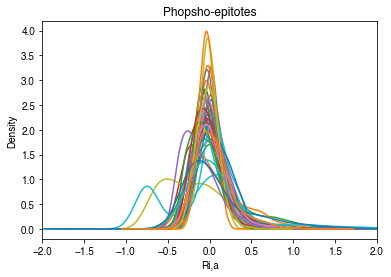

In [9]:
# Get the median of all control cells
ctr_median = dat_use.loc[cell_annot["EGF"]].median()
dat_scaled = (dat_use - ctr_median)/ctr_median

rglob_mra = dat_scaled[ab_use_phospho].transpose()
# Make clean names for the node names
rglob_mra.index = [ab_mapping[ab_name] for ab_name in rglob_mra.index]
rglob_mra.transpose()[NODE_NAMES].plot.kde(legend=False);
plt.xlabel("Ri,a");
plt.ylabel("Density");
plt.xlim(-2, 2)
plt.title("Phopsho-epitotes");

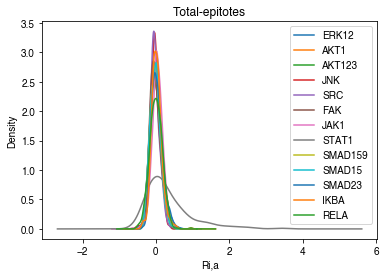

In [10]:
nn, an = zip(*[(nn, an) for nn, an in ab_mapping_tot_inv.items()])
rtot_mra = dat_scaled[list(an)].transpose()
rtot_mra.index = nn
rtot_mra.transpose().plot.kde();
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Total-epitotes");

In [11]:
scd_mra = scmra.ScData(rglob_mra, rtot_mra, cell_annot=cell_annot, tx_annot=tx_annot)
ALPHA = scmra.sccplex.estimate_alpha(scd_mra)

Beware: Rows of perturbation data are reordered:
old:	['EGFRY1045', 'EGFRY1173', 'ERK12', 'RSK1T359', 'AKT1', 'AKT123', 'MTOR', 'GSK3B', 'RPS6', 'JNK', 'CJUN', 'ITGB1', 'SRC', 'FAK', 'JAK1', 'STAT1', 'STAT3', 'STAT5', 'LRP6', 'FZD', 'BMP', 'BMPR', 'SMAD159', 'SMAD15', 'SMAD23', 'MKK36', 'P38', 'P38D', 'MAPKAP2', 'CREB', 'IKBA', 'P65', 'RELA', 'CFOS', 'CMYC', 'CDC2', 'CDK4', 'CYCLINE', 'CYCLINB1', 'H2A', 'H3', 'RB']
new:	['ERK12', 'AKT1', 'AKT123', 'JNK', 'SRC', 'FAK', 'JAK1', 'STAT1', 'SMAD159', 'SMAD15', 'SMAD23', 'IKBA', 'RELA', 'EGFRY1045', 'EGFRY1173', 'RSK1T359', 'MTOR', 'GSK3B', 'RPS6', 'CJUN', 'ITGB1', 'STAT3', 'STAT5', 'LRP6', 'FZD', 'BMP', 'BMPR', 'MKK36', 'P38', 'P38D', 'MAPKAP2', 'CREB', 'P65', 'CFOS', 'CMYC', 'CDC2', 'CDK4', 'CYCLINE', 'CYCLINB1', 'H2A', 'H3', 'RB']
Estimating best value for alpha
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 718.436099 after 0.01 sec. (1.57 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 15484 rows a

In [14]:
%%capture

# sols_eta_mra = dict()

# # Get "Empty" solution as reference
# scp = scmra.ScMraProblem(scd_mra, eta=0., alpha=ALPHA)
# scmra.sccplex.set_interactions_status(scp, ALL_EDGES, 0)
# scp.cpx.solve()
# sols_eta_mra[1] = scmra.ScMraResult(scp)

# # Get solution with all cannonical edges
# scp = scmra.ScMraProblem(scd_mra, eta=0., alpha=ALPHA)
# scmra.sccplex.set_interactions_status(scp, CANNONICAL_EDGES, 1)
# # Set all other edges to 0
# scmra.sccplex.set_interactions_status(scp, list(set(ALL_EDGES) - set(CANNONICAL_EDGES)), 0)
# scp.cpx.solve()
# sols_eta_mra[.99] = scmra.ScMraResult(scp)


#ETA_VALS = [0, 0.6, 0.7, 0.8, 0.7, 0.9]
# ETA_VALS = [0.5]

# for eta_val in ETA_VALS:
#     scp = scmra.ScMraProblem(scd_mra, eta=eta_val, alpha=ALPHA)
#     scmra.sccplex.set_interactions_status(scp, CANNONICAL_EDGES, 1)
#     scmra.sccplex.set_interactions_status(scp, OUTPUT_EDGES, 0)
#     scmra.sccplex.set_interactions_status(scp, INPUT_EDGES, 0)
#     scp.cpx.solve()
#     sols_eta_mra[eta_val] = scmra.ScMraResult(scp)

#     f = open("tmp.txt", "w")
#     f.write(str(eta_val))
#     f.close()

#     with open('../../results/scIDseq/full-network-mra-eta-scan.pickle', 'wb') as f:
#         pickle.dump(sols_eta_mra, f)    


# load sols_eta_mra
with open('../results/full-network-mra-eta-scan.pickle', 'rb') as f:
    sols_eta_mra = pickle.load(f)

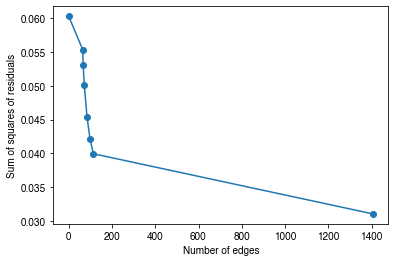

In [15]:
tmp = sorted([(s.n_edges, s.mssr) for s in sols_eta_mra.values()])
plt.plot(*zip(*tmp), '-o');
plt.xlabel("Number of edges");
plt.ylabel("Sum of squares of residuals");

For computational reasons, we fix the network topology to the one obtained from $\eta=0.6$ for now.


In [17]:
def added_edges(solution, given_edges):
    diff_edges = []
    for i, j in np.nditer(np.nonzero(np.array(solution.imap))):
        diff_edges.append((solution.nodes[i], solution.nodes[j]))
    return set(diff_edges) - set(given_edges)


selected_additions = list(added_edges(sols_eta_mra[0.6], CANNONICAL_EDGES))
SELECTED_EDGES = CANNONICAL_EDGES + selected_additions
UNSELECTED_EDGES = list(set(ALL_EDGES) - set(SELECTED_EDGES))

with open("../results/mra_added_edges.txt", "w") as f:
            f.write('\n'.join('%s %s' % x for x in  selected_additions))

### Random networks to assess model significance

To assess the validity of the obtained model topology, we also calculate the mean RMS of residuals for 100 networks with randomly selected edges.

In [18]:
%%capture

# ALL_EDGES = SELECTED_EDGES + UNSELECTED_EDGES
# N_EDGES = len(SELECTED_EDGES)

# lst_mssr = []

# for perm in range(400):
    
#     # Select 99 random edges and set the rest to 0
#     perm_1 = random.sample(ALL_EDGES, N_EDGES)
#     perm_0 = list(set(ALL_EDGES) - set(perm_1))
    
#     perm_scp = scmra.ScMraProblem(scd_mra, eta=0., alpha=ALPHA)
#     scmra.sccplex.set_interactions_status(perm_scp, perm_1, 1)
#     scmra.sccplex.set_interactions_status(perm_scp, perm_0, 0)
#     perm_scp.cpx.solve()
#     perm_sol = scmra.ScMraResult(perm_scp)
#     lst_mssr.append(perm_sol.mssr)

#     with open("../../results/scIDseq/mra_random_network_mssr-batch2.txt", "w") as f:
#         for item in lst_mssr:
#             f.write("%s\n" % item)


## Comparative network reconstruction of the cell state clusters.

Finally, we want to explore the effect of cell state on the signaling network. To do this, we perform comparative network reconstruction of one cluster against the mean of all other clusters. 


Beware: Rows of perturbation data are reordered:
old:	['EGFRY1045', 'EGFRY1173', 'ERK12', 'RSK1T359', 'AKT1', 'AKT123', 'MTOR', 'GSK3B', 'RPS6', 'JNK', 'CJUN', 'ITGB1', 'SRC', 'FAK', 'JAK1', 'STAT1', 'STAT3', 'STAT5', 'LRP6', 'FZD', 'BMP', 'BMPR', 'SMAD159', 'SMAD15', 'SMAD23', 'MKK36', 'P38', 'P38D', 'MAPKAP2', 'CREB', 'IKBA', 'P65', 'RELA', 'CFOS', 'CMYC', 'CDC2', 'CDK4', 'CYCLINE', 'CYCLINB1', 'H2A', 'H3', 'RB']
new:	['ERK12', 'AKT1', 'AKT123', 'JNK', 'SRC', 'FAK', 'JAK1', 'STAT1', 'SMAD159', 'SMAD15', 'SMAD23', 'IKBA', 'RELA', 'EGFRY1045', 'EGFRY1173', 'RSK1T359', 'MTOR', 'GSK3B', 'RPS6', 'CJUN', 'ITGB1', 'STAT3', 'STAT5', 'LRP6', 'FZD', 'BMP', 'BMPR', 'MKK36', 'P38', 'P38D', 'MAPKAP2', 'CREB', 'P65', 'CFOS', 'CMYC', 'CDC2', 'CDK4', 'CYCLINE', 'CYCLINB1', 'H2A', 'H3', 'RB']


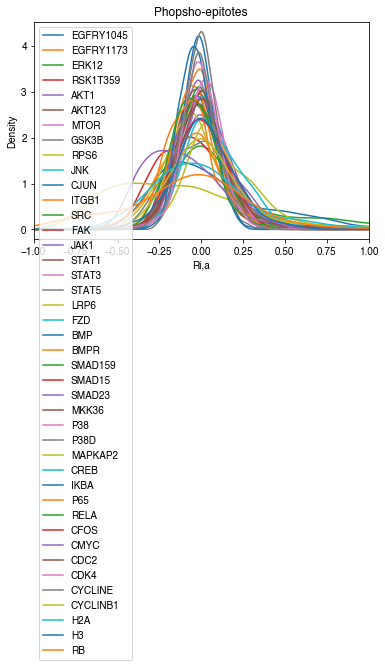

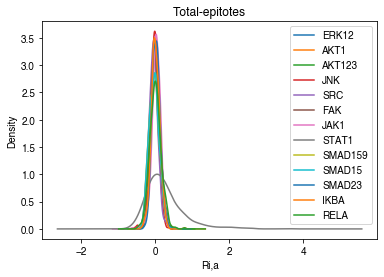

In [19]:
df_lst = []
# For each cluster
for clust_id, cells in group_annot.items():
    # Get median of EGF treated cells.
    ctr_cells = set(cells).intersection(cell_annot["EGF"])
    ctr_median = dat.loc[ctr_cells].median()

    # Median center cells per cluster
    dat_scaled = (dat.loc[cells] - ctr_median) / ctr_median
    #dat_scaled = dat_scaled.transpose()
    df_lst.append(dat_scaled)
    
# Combine data from all clusters again (and retain old cell order) 
dat_scaled = pd.concat(df_lst, axis=0).loc[dat.index]
rglob_cnr = dat_scaled[ab_use_phospho].transpose()
rglob_cnr.index = [ab_mapping_phospho[ab] for ab in rglob_cnr.index]

abs_use, nodes_use = zip(*[(ab, node) for node, ab in ab_mapping_tot_inv.items()])

rtot_cnr = dat_scaled[list(abs_use)].transpose()
rtot_cnr.index = nodes_use
del abs_use, nodes_use

scd_cnr = scmra.ScData(
    rglob_cnr, rtot_cnr, 
    group_annot=group_annot, cell_annot=cell_annot, tx_annot=tx_annot
)


# Plot the disctributions
rglob_cnr.transpose().plot.kde();
plt.xlim(-1, 1)
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Phopsho-epitotes");
#plt.get_legend().remove()
plt.show();

rtot_cnr.transpose().plot.kde();
plt.xlabel("Ri,a");
plt.ylabel("Density")
plt.title("Total-epitotes");


<Figure size 1080x720 with 0 Axes>

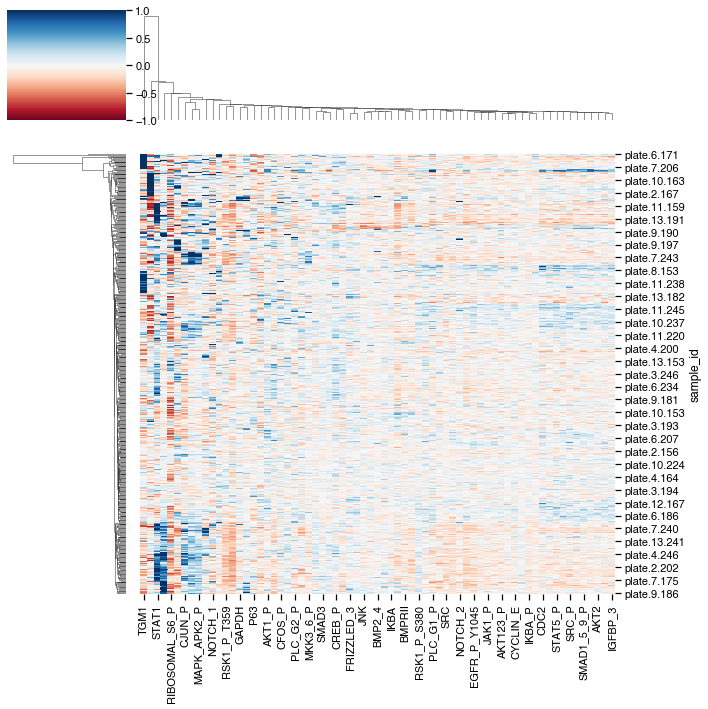

In [20]:
sns.set_context('notebook')
fig = plt.figure(figsize=(15, 10))
sns.clustermap(
    dat_scaled, 
    annot=None, linewidths=.0, cbar=True, cmap="RdBu", center=0,
    vmin=-1, vmax=1
)
plt.tight_layout()


In [21]:
%%capture
sols_theta = dict()
THETA_VALS = [0, 0.1, 0.15, 0.2, 0.35, 0.5, 1, 10]

for theta in THETA_VALS:
    scp = scmra.ScCnrProblem(scd_cnr, eta=0.,  theta=theta, alpha=ALPHA)
    scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
    scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
    scp.cpx.solve()
    sols_theta[theta] = scmra.ScCnrResult(scp)
    with open('../results/theta-scan.pickle', 'wb') as f:
        pickle.dump(sols_theta, f)
# with open('../../results/scIDseq/theta-scan-all.pickle', 'rb') as f:
#     sols_theta = pickle.load(f)

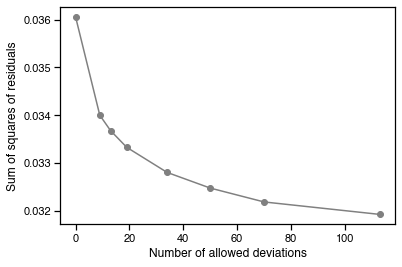

In [22]:
tmp = sorted([(
    sum(s.allowed_deviations.values()), 
    np.mean(np.array(np.square(pd.concat([s.residuals_incomplete, s.residuals_complete]))).flatten())) 
    for s in sols_theta.values()])
plt.plot(*zip(*tmp), '-o', c="gray");
plt.xlabel("Number of allowed deviations");
plt.ylabel("Sum of squares of residuals");


In [23]:
THETA = 0.2
sol_ref = sols_theta[THETA]

In [24]:
sum(sol_ref.allowed_deviations.values())

34.0

### Bootstraps

In [22]:
%%capture

sol_bootstrap_cnr=[]
NBOOTSTRAP = 100
NBSTRPCELLS=len(rglob_cnr.columns)
for bstr in range(NBOOTSTRAP):
    bstrp_cells = random.choices(list(rglob_cnr.columns), k=NBSTRPCELLS)
    bstrp_cell_names = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]
    bstrp_rglob = rglob_cnr[bstrp_cells]
    bstrp_rglob.columns = bstrp_cell_names
    bstrp_rtot = rtot_cnr[bstrp_cells]
    bstrp_rtot.columns = bstrp_cell_names
    bstrp_df_annot = df_annot.loc[bstrp_cells]
    bstrp_df_annot["bstrp_id"] = ['b'+str(idx)+"."+bstrp_cells[idx] for idx in range(NBSTRPCELLS)]

    bstrp_cell_annot = dict()
    for tx in bstrp_df_annot.treatment.unique():
        bstrp_cell_annot[tx] = list(bstrp_df_annot[bstrp_df_annot.treatment == tx].bstrp_id)

    bstrp_group_annot = dict()
    for group in bstrp_df_annot.cluster.unique():
        bstrp_group_annot[str(group)] = list(bstrp_df_annot[bstrp_df_annot.cluster == group].bstrp_id)

    scd = scmra.ScData(bstrp_rglob, bstrp_rtot, group_annot=bstrp_group_annot, cell_annot=bstrp_cell_annot, tx_annot=tx_annot)
    scp = scmra.ScCnrProblem(scd, eta=0., theta=THETA, alpha=ALPHA)
    scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
    scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
    scp.cpx.solve()
    sol_bootstrap_cnr.append(scmra.ScCnrResult(scp))
    if bstr % 10 == 0:
        with open('../results/bootstraps/cnr_full.pickle', 'wb') as f:
            pickle.dump(sol_bootstrap_cnr, f)


### Sample permutation

In [11]:

def perform_sample_permutation_restricteddevs(dat_scaled, df_annot, ref_sol):        

    # Get random assignment of samples to groups
    # Keep same number of cells and treatment per group
    df_lst_annot = []
    # For each treatment seperately, shuffel the cluster assignment
    for tx in set(df_annot.treatment):
        tmp = df_annot.copy(deep=True)
        tmp = tmp[tmp.treatment == tx]
        lst = list(tmp.cluster) 
        random.shuffle(lst)
        tmp.cluster = lst
        df_lst_annot.append(tmp)
    perm_annot = pd.concat(df_lst_annot)
    
    # Get random assignment of samples to groups
    group_annot_perm = dict()
    for group in perm_annot.cluster.unique():
        group_annot_perm[str(group)] = list(perm_annot[perm_annot.cluster == group].index)
    del df_lst_annot, tmp
    
    # Rescale data based on new cluster assignments
    # dat_scaled = rescale_data(dat, group_annot_perm)

    abs_use, nodes_use = zip(*[(ab, node) for node, ab in ab_mapping_tot_inv.items()])
    rglob_perm = dat_scaled[ab_use_phospho].transpose()
    rglob_perm.index = [ab_mapping_phospho[ab] for ab in rglob_perm.index]
    rtot_perm = dat_scaled[list(abs_use)].transpose()
    rtot_perm.index = nodes_use
    del abs_use, nodes_use

    # Run the CNR optimization
    scd = scmra.ScData(rglob_perm, rtot_perm, group_annot=group_annot_perm, 
                       cell_annot=cell_annot, tx_annot=tx_annot)

    scp = scmra.ScCnrProblem(scd, eta=0., theta=0., alpha=ref_sol.hyperparameters['alpha'])
    scmra.sccplex.set_interactions_status(scp, SELECTED_EDGES, 1)
    scmra.sccplex.set_interactions_status(scp, UNSELECTED_EDGES, 0)
    for indicator, status in ref_sol.vardict.items():
        if indicator.startswith(("IDev", "ISDev", "IPDev")):
            scmra.cplexutils.set_indicator_status(scp.cpx, indicator, status)

    scp.cpx.solve()
    sol = scmra.ScCnrResult(scp)
    return sol


In [22]:
%%capture

sol_permutations_cnr_restricteddevs=[]
NPERMUTATOINS = 14

for perm in range(NPERMUTATOINS):
    sol = perform_sample_permutation_restricteddevs(dat_scaled, df_annot, sol_ref)
    sol_permutations_cnr_restricteddevs.append(sol)
    
    # Save after every twenty permutations
    if perm % 20 == 0:
    with open('../results/sample-permutation/cnr_full-restricteddevs_batch1.pickle', 'wb') as f:
        pickle.dump(sol_permutations_cnr_restricteddevs, f)
        